In [2]:
!git clone https://github.com/afozbek/Track_Data

Cloning into 'Track_Data'...
remote: Enumerating objects: 12850, done.
remote: Counting objects: 100% (12850/12850), done.
remote: Compressing objects: 100% (12850/12850), done.
remote: Total 12850 (delta 0), reused 12850 (delta 0), pack-reused 0
Receiving objects: 100% (12850/12850), 156.69 MiB | 39.89 MiB/s, done.
Checking out files: 100% (13036/13036), done.


In [3]:
!ls Track_Data

driving_log.csv  IMG


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import ntpath
import random

In [5]:
datadir = 'Track_Data'
columns = ['center', 'left', 'right',
           'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'),
             names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\center_2019_01_29_18_32_35_352.jpg,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\left_2019_01_29_18_32_35_352.jpg,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\right_2019_01_29_18_32_35_352.jpg,0.0,0.0,0.0,0.000084
1,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\center_2019_01_29_18_32_35_454.jpg,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\left_2019_01_29_18_32_35_454.jpg,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\right_2019_01_29_18_32_35_454.jpg,0.0,0.0,0.0,0.000080
2,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\center_2019_01_29_18_32_35_560.jpg,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\left_2019_01_29_18_32_35_560.jpg,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\right_2019_01_29_18_32_35_560.jpg,0.0,0.0,0.0,0.000079
3,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\center_2019_01_29_18_32_35_664.jpg,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\left_2019_01_29_18_32_35_664.jpg,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\right_2019_01_29_18_32_35_664.jpg,0.0,0.0,0.0,0.000078
4,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\center_2019_01_29_18_32_35_785.jpg,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\left_2019_01_29_18_32_35_785.jpg,C:\Users\Furkan-Ozbek\Desktop\DATA\IMG\right_2019_01_29_18_32_35_785.jpg,0.0,0.0,0.0,0.000080


In [6]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_01_29_18_32_35_352.jpg,left_2019_01_29_18_32_35_352.jpg,right_2019_01_29_18_32_35_352.jpg,0.0,0.0,0.0,0.000084
1,center_2019_01_29_18_32_35_454.jpg,left_2019_01_29_18_32_35_454.jpg,right_2019_01_29_18_32_35_454.jpg,0.0,0.0,0.0,0.000080
2,center_2019_01_29_18_32_35_560.jpg,left_2019_01_29_18_32_35_560.jpg,right_2019_01_29_18_32_35_560.jpg,0.0,0.0,0.0,0.000079
3,center_2019_01_29_18_32_35_664.jpg,left_2019_01_29_18_32_35_664.jpg,right_2019_01_29_18_32_35_664.jpg,0.0,0.0,0.0,0.000078
4,center_2019_01_29_18_32_35_785.jpg,left_2019_01_29_18_32_35_785.jpg,right_2019_01_29_18_32_35_785.jpg,0.0,0.0,0.0,0.000080


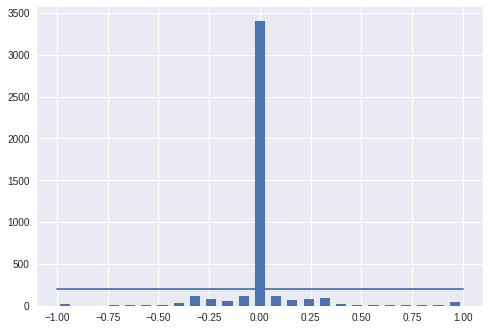

In [7]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),
        (samples_per_bin, samples_per_bin))

total data: 4345
removed 3202
remaining 1143


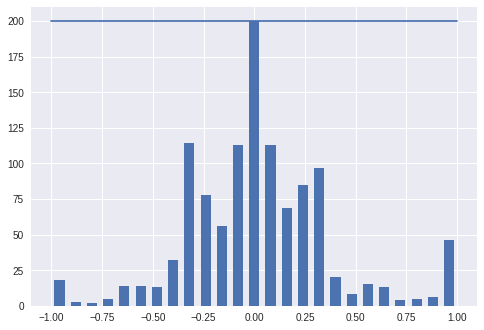

In [8]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j + 1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),
        (samples_per_bin, samples_per_bin))

In [12]:
print(data.iloc[1]) #iloc-->records based on the indexes
def load_img_steering(datadir, data):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  #Convert the input to an array.  
  image_paths = np.asarray(image_path) 
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

center      center_2019_01_29_18_32_37_167.jpg
left        left_2019_01_29_18_32_37_167.jpg  
right       right_2019_01_29_18_32_37_167.jpg 
steering   -0.301282                          
throttle    0.301282                          
reverse     0                                 
speed       0.619281                          
Name: 17, dtype: object


In [0]:
#Split arrays or matrices into random train and test subsets
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

In [23]:
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 914
Valid Samples: 229


Text(0.5, 1.0, 'Valid set')

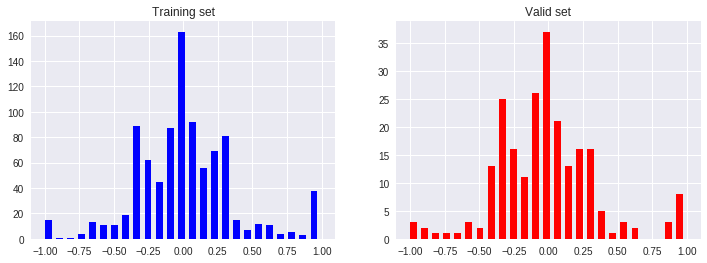

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Valid set')